# <center> Voter model with zealots for social opinion evolution

This is the python code used to produce the plots in <i>Voter model with zealots for social opinion evolution</i>. We follow the paper organisation. Parameters are set to the one used in the paper but are free to change. Custom functions for our simulations are in `util.py`.

We import the requested modules and set up some parameters for the plots appearance.

In [1]:
# imports
import sys
import numpy as np
import pickle
from time import time
from random import sample
from scipy.stats import norm
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.lines import Line2D
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fs = 10 # fontsize for plots

# our functions for simulations
from util import section4_simu, section5_simu, polarisation, Qmatrix, stationary, mixing_time

# for confidence intervals
quant = norm().ppf(0.95)

# latex rendering
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
rc('text', usetex=True)
rc('legend', frameon=False) # PS doesn't do well with transparencies

## Graph evolution
Now we're gonna draw the graph and the evolution of opinions within (figure 1 and 2).

In [2]:
n = 50
n1 = 10
z0, z1 = 5, 2 
n_simu = 1
max_time = 40
spacing_simu = 1
seed = None
length = int(np.floor(max_time/spacing_simu)+1)

Simulation.

In [ ]:
N1t = section5_simu(n, n1, z1, z0, max_time, spacing_simu, seed)
N1t = N1t.astype(int)

Save for re-use, or load from previous run. `./simu_results/graphevolve1.p` and `./simu_results/graphevolve2.p` were used in the paper.

In [3]:
name = "./simu_results/graphevolve1.p"
#pickle.dump(N1t, open(name, "wb")) # save
N1t = pickle.load(open(name, "rb")) # load

<b>Figure 1-2.</b>

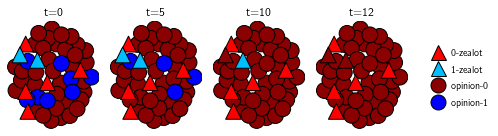

In [4]:
fig, ax = plt.subplots(1,4, figsize=(7,2))
plot_times = (0,5,10,12)
        
# create graph
G = nx.Graph()
for k in range(n):
    if k<z0 or k>=n-z1:
        G.add_node(k, s="^")
    else:
        G.add_node(k, s="o")
    for l in range(k):
        G.add_edge(l,k)

# get node pos and all distinct node classes according to the node shape attribute
pos = nx.layout.spring_layout(G, scale=1)
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data=True)))

# look at different times
for i,t in enumerate(plot_times):
    n0t, n1t = n-N1t[t]-z0, N1t[t]-z1
    color = ["red"]*z0 + ["darkred"]*n0t + ["blue"]*n1t + ["deepskyblue"]*z1

    # draw nodes
    for aShape in nodeShapes:
        node_list = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape, G.nodes(data=True))]
        color_list = [color[k] for k in node_list]
        nx.draw_networkx_nodes(G, pos, ax=ax[i], node_size=250, node_color=color_list, node_shape=aShape, nodelist=node_list, edgecolors="black")
        ax[i].axis("off")
        ax[i].set_title("t={}".format(t))
        
    # draw edges if needed
    #nx.draw_networkx_edges(G, pos, ax=axis, width=.1)

# legend
legend_elements = list()
legend_elements += [Line2D([0], [0], marker="^", color="w", label="0-zealot", markerfacecolor="red", markeredgecolor="black", markersize=15)]
if z1>0:
    legend_elements += [Line2D([0], [0], marker="^", color="w", label="1-zealot", markerfacecolor="deepskyblue", markeredgecolor="black", markersize=15)]
legend_elements += [Line2D([0], [0], marker="o", color="w", label="opinion-0", markerfacecolor="darkred", markeredgecolor="black", markersize=15)]
legend_elements += [Line2D([0], [0], marker="o", color="w", label="opinion-1", markerfacecolor="blue", markeredgecolor="black", markersize=15)]
if z1>0:
    plt.legend(handles=legend_elements, edgecolor="w", labelspacing=.6, fontsize=fs, handletextpad=.25, borderpad=.2, loc=(1.2,0.18))
else:
    plt.legend(handles=legend_elements, edgecolor="w", labelspacing=.6, fontsize=fs, handletextpad=.25, borderpad=.2, loc=(1.2,0.27))

# show
plt.tight_layout()
plt.show()
plt.close()

# Validation of N1t distrib, equilibrium and mixing times

For figures 3 and 4.

In [5]:
n = 100
N1_init = np.array([25,75])
Z = [(10,5), (20,25)]
n_simu = 1000
max_time = 40
spacing_simu = 2
seed = None
k_range_eps = range(2,6)
Epsilon = np.array([10**(-k) for k in k_range_eps]) 
spacing_mix = .1
length = int(np.floor(max_time/spacing_simu)+1)

Simulate using custom function from `util.py`, or load previous results in next cell.

In [ ]:
N1t = np.zeros((n_simu, N1_init.size, len(Z), length))
start = time()

for j,(z0,z1) in enumerate(Z):
    for i,n1 in enumerate(N1_init):
        for k in range(n_simu):
            sys.stdout.flush()
            sys.stdout.write("n1={}, z1={}, z0={}. Simu {}/{}. Elapsed time {}\r".format(n1, z1, z0, k+1, n_simu, round(time()-start,1)))
            N1t[k,i,j,:] = section5_simu(n, n1, z1, z0, max_time, spacing_simu, seed)

Save result or load previous simulations results if needed. `./simu_results/N1t.p` was used in the paper.

In [6]:
name = "./simu_results/N1t.p"
N1t = pickle.load(open(name, "rb")) # load
#pickle.dump(N1t, open(name, "wb")) # save

Compute transition rate Q matrix from system (2) in the paper.

In [7]:
Q = {j: Qmatrix(n,z0,z1) for j,(z0,z1) in enumerate(Z)}

Compute theoretical values for $\mathbb{E}N_1^{(t)}$ using Theorem 2 and also according to Ref.[4] (On the role of zealotry...) eq5.

In [8]:
x_axis = np.linspace(0, max_time, length)
expect = {"markov":np.zeros((N1_init.size, len(Z), length)), "ref19":np.zeros((N1_init.size, len(Z), length))}

for j,(z0,z1) in enumerate(Z):
    z = z0+z1
    for c,t in enumerate(x_axis):
        Pt = expm(t*Q[j])
        k_range = np.arange(z1,n-z0+1)
        for i,n1 in enumerate(N1_init):
            expect["markov"][i,j,c] = k_range.dot(Pt[n1-z1,:])
            expect["ref19"][i,j,c] = z1 + z1*(n-z)/z + (n1-z1 - z1*(n-z)/z) * np.exp(-z/n*t) # ref19

Compare `expectation` and `ref19` with empirical averages.

In [9]:
Mean, Min, Max = list(), list(), list()
for j,(z0,z1) in enumerate(Z):
    print("(z0,z1) = {}".format(z0,z1))
    for i,n1 in enumerate(N1_init):
        print("\tn1 = {}".format(n1))
        mean = np.mean(N1t[:,i,j,:], axis=0)
        for label,exp in expect.items():
            if label == "ref19":
                continue
            diff = np.abs(mean-exp[i,j])
            print("\t\tmax = {:.4f}, min = {:.4f}, mean = {:.4f}, median = {:.4f}".format(np.max(diff), np.min(diff), np.mean(diff), np.median(diff)))
            Mean.append(np.mean(diff))
            Min.append(np.min(diff))
            Max.append(np.max(diff))
print("Overall: mean {} min {} max {}".format(np.mean(Mean), min(Min), max(Max)))

(z0,z1) = 10
	n1 = 25
		max = 0.7670, min = 0.0000, mean = 0.2999, median = 0.2323
	n1 = 75
		max = 0.3147, min = 0.0000, mean = 0.1507, median = 0.1401
(z0,z1) = 20
	n1 = 25
		max = 0.2978, min = 0.0000, mean = 0.1012, median = 0.0906
	n1 = 75
		max = 0.3166, min = 0.0000, mean = 0.1069, median = 0.0921
Overall: mean 0.1646729037807303 min 0.0 max 0.7669896660332824


Compare `expectation` and `ref19` with each other.

In [10]:
Mean, Min, Max = list(), list(), list()
for j,(z0,z1) in enumerate(Z):
    print("(z0,z1) = {}".format(z0,z1))
    for i,n1 in enumerate(N1_init):
        print("\tn1 = {}".format(n1))
        diff = np.abs(expect["ref19"][i,j]-expect["markov"][i,j])
        print("\t\tmax = {:.4f}, min = {:.4f}, mean = {:.4f}, median = {:.4f}".format(np.max(diff), np.min(diff), np.mean(diff), np.median(diff)))
        Mean.append(np.mean(diff))
        Min.append(np.min(diff))
        Max.append(np.max(diff))
print("Overall: mean {} min {} max {}".format(np.mean(Mean), min(Min), max(Max)))

(z0,z1) = 10
	n1 = 25
		max = 0.0307, min = 0.0000, mean = 0.0129, median = 0.0101
	n1 = 75
		max = 0.1533, min = 0.0000, mean = 0.0647, median = 0.0504
(z0,z1) = 20
	n1 = 25
		max = 0.1124, min = 0.0000, mean = 0.0151, median = 0.0001
	n1 = 75
		max = 0.0715, min = 0.0000, mean = 0.0096, median = 0.0001
Overall: mean 0.025578380202096504 min 0.0 max 0.1533057588108946


Compute mixing times.

In [11]:
mixing = np.zeros((Epsilon.size, N1_init.size, len(Z)))
start = time()
for j,(z0,z1) in enumerate(Z):
    pi = stationary(n,z0,z1,Q[j])
    for i,n1 in enumerate(N1_init):
        for k,eps in enumerate(Epsilon):
            sys.stdout.flush()
            sys.stdout.write("Z {}/{}. eps {}/{}. n1 {}/{}. Elapsed time {}\r"
                             .format(j+1, len(Z), k+1, Epsilon.size, j+1, N1_init.size, round(time()-start,1)))
            mixing[k,i,j] = mixing_time(n, n1, z0, z1, Q[j], pi, eps, spacing_mix)

Parameters for plots appearance.

In [12]:
color = ["blue", "red", "green", "orange"]
color_alpha = ["lavender", "mistyrose", "lightgreen", "moccasin"]
letter = "abcdefghijklmnopqrstuvwxyz"
marker = "x+*^p"
linestyle = ["--", "-.", ":", "-", (0,(3, 5, 1, 5))] # last one is dashdotdotted from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html

<b>Figure 3:</b> empirical vs theoretical distributions vs stationary at different chosen points in time.

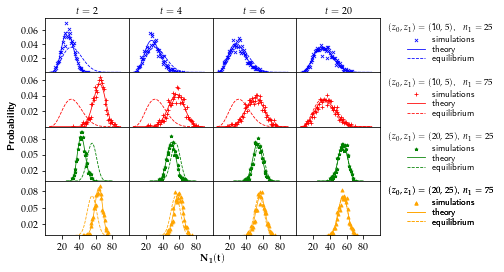

In [13]:
n_cases = len(Z)*N1_init.size
timestamp = [2,4,6,20]
time_index = [int(t/spacing_simu) for t in timestamp]
unique_emp, probs_emp, distrib_theo, steady, ref19 = dict(), dict(), dict(), dict(), dict() # distrib empirical, theoretical, stationary

# first, compute distribs and determine upper limit of y-axis, ie maximum proba
# also compute errors
ymax = [-1]*n_cases
c = 0 # counter for axes indices
for j,(z0,z1) in enumerate(Z):
    for i,n1 in enumerate(N1_init):
        steady[j,i] = stationary(n,z0,z1,Q[j]) # stationary
        for k,t in enumerate(timestamp):
            tt = time_index[k]
            unique_emp[j,i,k], count = np.unique(N1t[:,i,j,tt], return_counts=True)
            probs_emp[j,i,k] = count/count.sum() # transform counts into proportions
            distrib_theo[j,i,k] = expm(t*Q[j])[n1-z1,:] # theoretical
            ymax[c] = max([ymax[c], probs_emp[j,i,k].max(), distrib_theo[j,i,k].max(), steady[j,i].max()])
        ymax[c] = 1.1*ymax[c] # add 10% for extra padding
        c += 1 # increment counter

# then plot
fig, ax = plt.subplots(n_cases, len(timestamp))
fig.subplots_adjust(hspace=0, wspace=0)
c = 0 # counter for axes indices and appearance of plots
for j,(z0,z1) in enumerate(Z):
    for i,n1 in enumerate(N1_init):
        for k,t in enumerate(timestamp):
            
            # plot
            scatter = ax[c,k].scatter(unique_emp[j,i,k], probs_emp[j,i,k], linewidth=.8, s=10, marker=marker[c], color=color[c])
            plot_steady, = ax[c,k].plot(range(z1, n-z0+1), steady[j,i], color=color[c], ls="--", linewidth=.8)#, alpha=.5)
            plot_theo, = ax[c,k].plot(range(z1, n-z0+1), distrib_theo[j,i,k], color=color[c], linewidth=.8)

            # ticks and appearance
            #ax[c,k].grid()
            ax[c,k].set_xlim(0,n)
            ax[c,k].set_ylim(0,ymax[c])
            if c==0:
                ax[c,k].set_xlabel("$t = {}$".format(t), fontsize=fs)
                ax[c,k].xaxis.set_label_position("top") 
            if c==1 and k==0:
                ax[c,k].set_ylabel(r"\textbf{Probability}", fontsize=fs)#, rotation=0)
                ax[c,k].yaxis.set_label_coords(-0.35, 0)
                #ax[c,k].yaxis.set_label_position("right") 
            if c==3 and k==2:
                ax[c,k].set_xlabel(r"$\mathbf{N_1(t)}$", fontsize=fs)
                ax[c,k].xaxis.set_label_coords(0, -.35)
            if k==0 and c<3:
                ax[c,k].tick_params(axis="x", which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
            if k>0 and c<3:
                ax[c,k].tick_params(axis="both", which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
            ax[c,k].set_xticks((20,40,60,80))
            if k>0:
                ax[c,k].tick_params(axis="y", which='both', bottom=False, top=False, left=False, right=False, labelleft=False) # no y-ticks
            if c>1:
                ax[c,k].set_yticks((0.02,0.05,0.08))
            else:
                ax[c,k].set_yticks((0.02,0.04,0.06))
                
        # legend 
        loc = (1.05, 3.1-c)
        elements = [scatter, plot_theo, plot_steady]
        names = ["simulations", "theory", "equilibrium"]
        if c<2: # differentiate so we can add extra space for the boxes to be all the same size
            title = "$(z_0,z_1) = ({},{})$, $\;\,n_1 = {}$".format(z0,z1,n1)
        else:
            title="$(z_0,z_1) = ({},{})$, $n_1 = {}$".format(z0,z1,n1)
        legend = plt.legend(elements, names, title=title, loc=loc, fancybox=False, labelspacing=.15, edgecolor="grey", fontsize=9)
        plt.setp(legend.get_title(), fontsize=9)
        plt.gca().add_artist(legend)
            
        # increment counter
        c += 1
        
# show
plt.show()
plt.close()

<b>Figure 4:</b> $\mathbb{E}N_1^{(t)}$, theoretical values and empirical averages with confidence intervals, and theoretical mixing times.

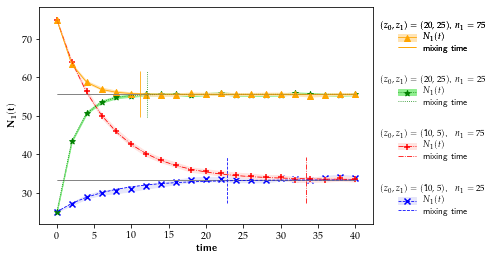

In [14]:
eps_bar_height = 6
count = -1

# plot
for j,(z0,z1) in enumerate(Z):
    
    for i,n1 in enumerate(N1_init):
        count += 1
        mean = np.mean(N1t[:,i,j,:], axis=0)
        std = np.std(N1t[:,i,j,:], axis=0, ddof=1)
        #fill_btw = plt.fill_between(x_axis, mean-quant*std/np.sqrt(n_simu), mean+quant*std/np.sqrt(n_simu), alpha=.1, color=color[count])
        fill_btw = plt.fill_between(x_axis, mean-quant*std/np.sqrt(n_simu), mean+quant*std/np.sqrt(n_simu), color=color_alpha[count])
        plot, = plt.plot(x_axis, expect["markov"][i,j], c=color[count], ls=linestyle[count], linewidth=.8)
        scatter = plt.scatter(x_axis, mean, c=color[count], marker=marker[count], label="n1 = {}".format(str(n1)))
        
        # limit and mixing time and limit
        limit = n*z1/(z0+z1)
        hline = plt.hlines(limit, 0, max_time, color="grey", linewidth=.8)
        for k,eps in enumerate(Epsilon):
            if k>0: # we choose to only represent the lowest mixing times
                break
            mix = mixing[k,i,j]
            if mix<max_time: # don't plot mixing times further than what was simulated
                mix_line = plt.vlines(mixing[k,i,j], limit-eps_bar_height, limit+eps_bar_height, ls=linestyle[count], linewidth=.8, color=color[count])#, alpha=.8)
                #mix_line = plt.arrow(mixing[k,i,j], limit+eps_bar_height, 0, -5, width=.11, color=color[count], linestyle=linestyle[count])
                #mix_line = plt.scatter(mixing[k,i,j], limit+5, c=color[count], marker=r"$\Bigg\downarrow$", s=50)
    
        # legend 
        loc = (1.01, 0.025+count/4)
        elements = [(fill_btw, plot, scatter), mix_line]
        names = ["$N_1(t)$", "mixing time"]
        if count<2: # differentiate so we can add extra space for the boxes to be all the same size
            title = "$(z_0,z_1) = ({},{})$, $\;\,n_1 = {}$".format(z0,z1,n1)
        else:
            title = "$(z_0,z_1) = ({},{})$, $n_1 = {}$".format(z0,z1,n1)
        legend = plt.legend(elements, names, title=title, loc=loc, fancybox=False, labelspacing=.15, fontsize=9, edgecolor="grey")
        plt.setp(legend.get_title(), fontsize=9)
        plt.gca().add_artist(legend)
        
# save
plt.xlabel(r"\textbf{time}")
plt.ylabel(r"$\mathbf{N_1(t)}$")
plt.show()
plt.close()

Compute errors.

In [15]:
error_abs, totalvar = list(), list()
for j,(z0,z1) in enumerate(Z):
    for i,n1 in enumerate(N1_init):
        for k,t in enumerate(timestamp):
            tt = time_index[k]
            unique_emp[j,i,k], count = np.unique(N1t[:,i,j,tt], return_counts=True)
            probs_emp[j,i,k] = count/count.sum() # transform counts into proportions
            distrib_theo[j,i,k] = expm(t*Q[j])[n1-z1,:] # theoretical
            totalvar_tmp = 0
            for l,x in enumerate(range(z1, n-z0+1)):
                if x not in unique_emp[j,i,k]:
                    error_abs.append(distrib_theo[j,i,k][l])
                    totalvar_tmp += distrib_theo[j,i,k][l]
                else:
                    index = np.where(unique_emp[j,i,k]==x)[0][0]
                    diff = np.abs(distrib_theo[j,i,k][l]-probs_emp[j,i,k][index])
                    error_abs.append(diff)
                    totalvar_tmp += diff
            totalvar.append(totalvar_tmp/2)
print("Error abs: mean {}, min {}, max {}".format(np.mean(error_abs), min(error_abs), max(error_abs)))
print("Total variation: mean {}, min {}, max {}".format(np.mean(totalvar), min(totalvar), max(totalvar)))

Error abs: mean 0.0019374693632158943, min 9.540161778264844e-21, max 0.02212246549587995
Total variation: mean 0.06878016239416423, min 0.05178797113094425, max 0.08883453340378256


## Mitigating polarisation
Code used for figure 5.

In [16]:
n = 100
Lambda = 0.5
z0_min, z0_max = 1, 100
alpha_min, alpha_max = 0.01, 1
z0_range = np.geomspace(z0_min, z0_max, 100)
alpha_range = np.geomspace(alpha_min, alpha_max, 100)
fs = 12 # fontsize for plots

Compute $z_1^\star$ values for the adding and converting methods.

In [17]:
method = ("add", "convert")
z0_plot = {m: list() for m in method}
alpha_plot = {m: list() for m in method}
z1_plot = {m: list() for m in method}

for i,z0 in enumerate(z0_range):
    for alpha in alpha_range:
        D = 1-Lambda-alpha*Lambda*z0
        if D>0 and not np.allclose(D,0): # second condition bc of weird float behaviour
            z1 = Lambda*z0/D
            
            # add to lists if suitable
            for m in method:
                if m=="convert" and (1+alpha)*z1+z0 > n:
                    pass
                else:
                    z1_plot[m].append(z1)
                    z0_plot[m].append(z0)
                    alpha_plot[m].append(alpha)

Compute the max alpha for convert method on a more refined scale.

In [18]:
size = 10000
z0_range_convert = np.linspace(z0_min, z0_max, size)
alpha_range_convert = np.linspace(alpha_max, alpha_min, size)
max_alpha_convert = list()

for i,z0 in enumerate(z0_range_convert):
    done = False 
    for alpha in alpha_range_convert:
        D = 1-Lambda-alpha*Lambda*z0
        if D>0 and not np.allclose(D,0):
            z1 = Lambda*z0/D
            if (1+alpha)*z1+z0<=n:
                max_alpha_convert.append(alpha)
                done = True # we found the max alpha
                break
    if not done: # stop if there is no valid alpha for this z0, it means it was the max z0
        break

# remove useless values in z0_range_convert and delete alpha_range_convert for memory
z0_range_convert = z0_range_convert[:i] 
del alpha_range_convert

<b>Figure5.</b>

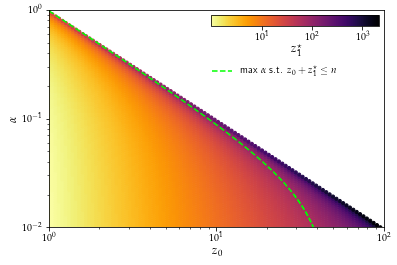

In [19]:
m = "add"
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

# plot
log_z1_plot = [np.log10(x) for x in z1_plot[m]]
scatter = ax.scatter(z0_plot[m], alpha_plot[m], c=log_z1_plot, cmap="inferno_r", marker=".", s=40)

# colorbar
cax = inset_axes(ax, width="50%", height="5%", loc="upper right") 
cbar = fig.colorbar(scatter, ticks=np.log10([1,10,100,1000,10000]), orientation="horizontal", cax=cax)
cax.xaxis.set_ticks_position("bottom")
cbar.ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$"])
cbar.ax.set_xlabel(r"$z_1^\star$", fontsize=fs)

# alpha_max for convert method
plot_convert, = ax.plot(z0_range_convert, max_alpha_convert, ls="--", color="lime")
label_convert = r"max $\alpha$ s.t. $z_0+z_1^\star \leq n$"

# legend
legend = plt.legend([plot_convert], [label_convert], loc=(-0.02,-5))#, labelspacing=.15, fontsize=9, edgecolor="grey")
for txt in legend.get_texts():
    txt.set_x(0) # x-position
    txt.set_y(-2) # y-position
    
# axes
ax.set_xlim(z0_min, z0_max)
ax.set_ylim(alpha_min, alpha_max)
ax.set_xlabel("$z_0$", fontsize=fs)
ax.set_ylabel(r"$\alpha$", fontsize=fs)

# show
plt.show()
plt.close()